# Adult Income Prediction notebook
This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). *The prediction task is to determine whether a person makes over  USD 50K a year.*  
This is a binary classification problem where we have to predict whether a person earns over $50k per year or not. The scoring function to optimize is accuracy. The notebook follows the following steps to analyse the data and build predictive models.
- Data cleaning and preprocessing
- Exploratory data analysis
- Modelling: I have tried out different classification algorithms.
  - Random forest
  - XGBoost
  - Naive Bayes
  - Logistic regression
  - CatBoost  
These models were then optimized by tuning the hyper-parameters through Grid Search, keeping a close check on the cross-validation scores to prevent overfitting. Thereafter I also tried out stacking different models together to improve the accuracy but it didn't improve the accuracy sigificantly.
- Finally I explored oversampling techniques including SMOTE.

Please feel free to suggest/comment.

In [1081]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1082]:
import os
import seaborn as sns
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [1083]:
sns.set() ##set defaults

In [1084]:
%matplotlib inline

In [1085]:
data = pd.read_csv("adult.csv")

In [1086]:
data.shape

(32561, 15)

In [1087]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [1088]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [1089]:
data['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [1090]:
data['income'].value_counts()    # Is the target variable skewed?

<=50K    24720
>50K      7841
Name: income, dtype: int64

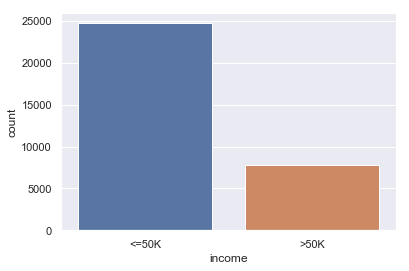

In [1091]:
sns.countplot(data['income'])

#### As one can see, there is considerable class imbalance in the target variable, i.e. income. This is also intuitively obvious as one expects fewer 'rich' people (earning>50k/annum) than 'not-so-rich' people (earning <50k/annum). Therefore we might need to consider over-sampling techniques in our ML model to improve our accuracy.

In [1092]:
data['income'] = data['income'].apply(lambda inc: 0 if inc == "<=50K" else 1) # Binary encoding of the target variable

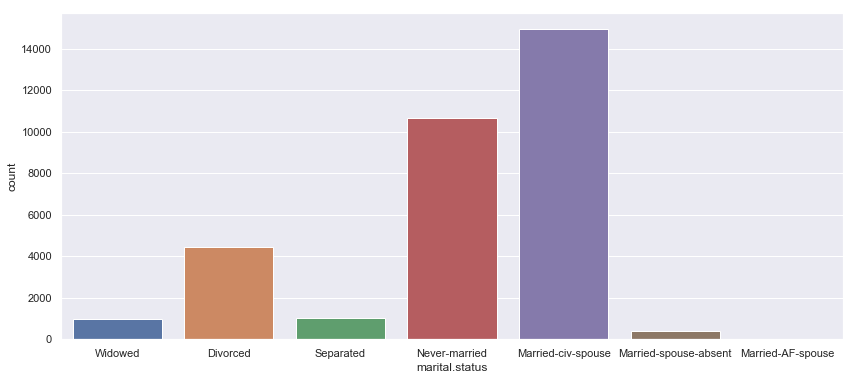

In [1093]:
plt.figure(figsize=(14,6))
sns.countplot(data['marital.status'])

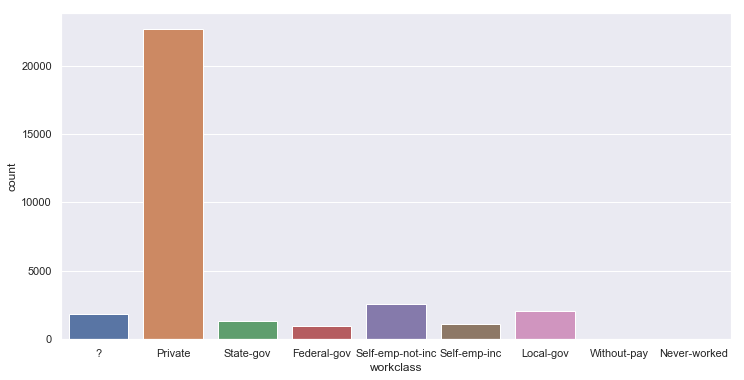

In [1094]:
plt.figure(figsize=(12,6))
sns.countplot(data['workclass'])

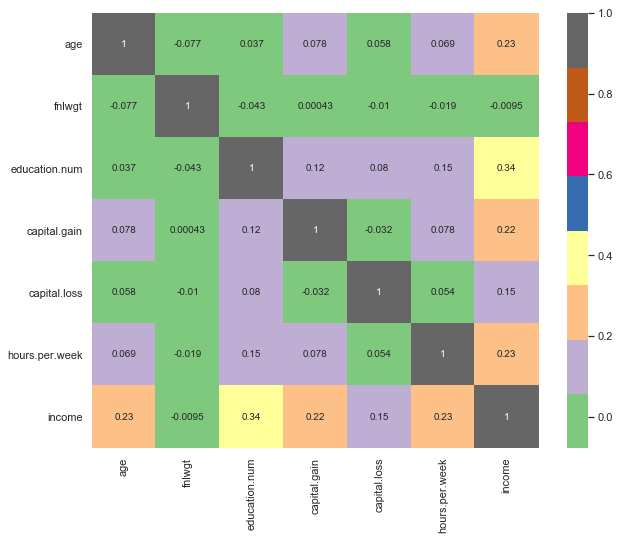

In [1095]:
plt.figure(figsize=(10,8))  
sns.heatmap(data.corr(),cmap='Accent',annot=True)
#data.corr()

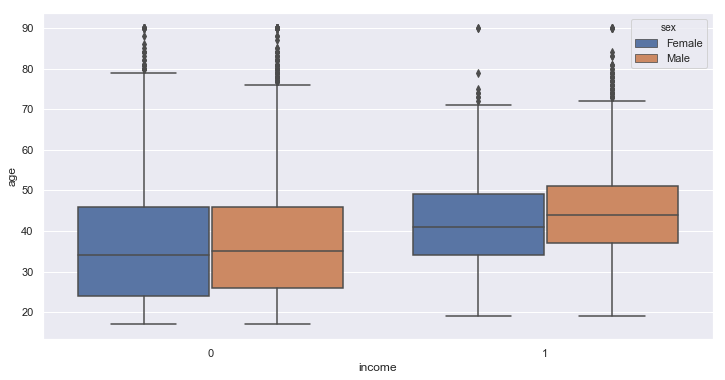

In [1119]:
plt.figure(figsize=(12,6))
sns.boxplot(x="income", y="age", data=data, hue='sex')
#data[data['income']==0]['age'].mean()

The mean age of people earning more than 50k per annum is around 44 whereas the mean age of of those earning less than 50k per annum is 36.

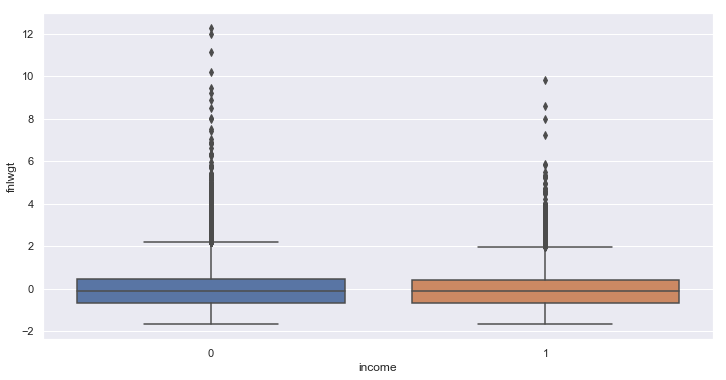

In [1097]:
norm_fnl = (data["fnlwgt"] - data['fnlwgt'].mean())/data['fnlwgt'].std()
plt.figure(figsize=(12,6))
sns.boxplot(x="income", y=norm_fnl, data=data)

As evident from the plot above, there are many outliers in the `fnlwgt` column and this feature is uncorrelated with `income`, our target variable. The correlation coefficient (which one can read from the heatmap) is -0.0095. The number of outliers, i.e. the number of records which are more than 2 s.d's away from the mean, is 1249.

In [947]:
data[norm_fnl>2].shape

(1249, 15)

[Text(0, 0.5, 'Income %age > $50k')]

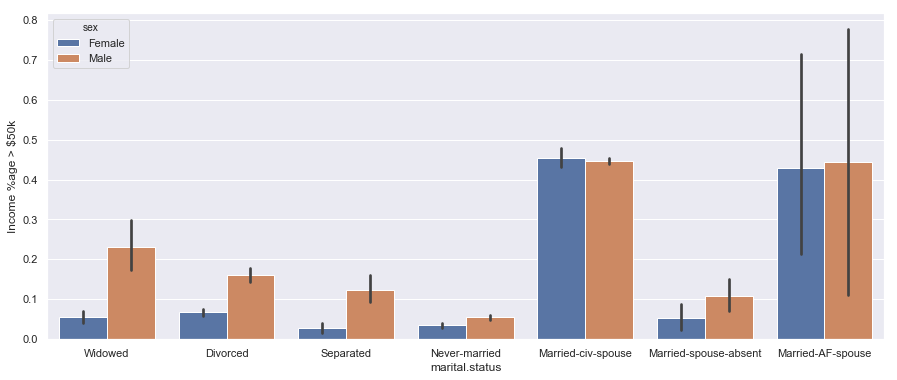

In [1113]:
plt.figure(figsize=(15,6))
ax=sns.barplot(x='marital.status',y='income',data=data,hue='sex')
ax.set(ylabel='Income %age > $50k')

The above plot shows the the fraction of people earning more than $50k per annum, grouped by their marital status and gender. The data shows that married people have a higher %age of high-earners. The black lines indicate the standard deviation in the data set. The married spouses of armed forces personnel have a much higher variation in their income compared to civil spouses.

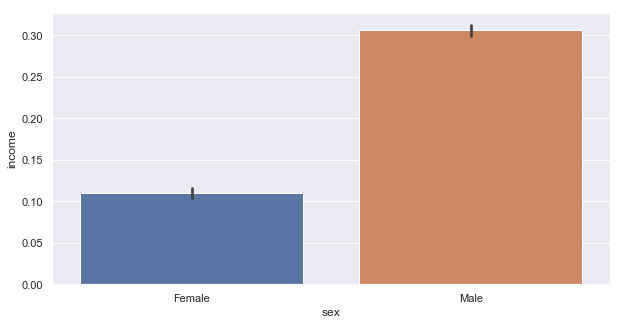

In [1109]:
plt.figure(figsize=(10,5))
sns.barplot(x='sex',y='income',data=data)

In [1106]:
data.select_dtypes(exclude=[np.number]).head()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
0,?,HS-grad,Widowed,?,Not-in-family,White,Female,United-States
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States
2,?,Some-college,Widowed,?,Unmarried,Black,Female,United-States
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States


In [948]:
data = data.applymap(lambda x: np.nan if x=='?' else x) #Replace all '?'s with NaNs.

In [949]:
data.isnull().sum(axis=0)

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [950]:
data.shape[0] - data.dropna(axis=0).shape[0]   # how many rows will be removed if I remove all the NaN's?

2399

In [951]:
data = data.dropna(axis=0) ## Drop all the NaNs

In [952]:
data.education.value_counts()  # I will label-encode the education column since it is an ordinal categorical variable

HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: education, dtype: int64

In [953]:
## This computes the fraction of people by country who earn >50k per annum
mean_income_bycountry_df = data[['native.country','income']].groupby(['native.country']).mean().reset_index()

In [954]:
edu_encode_dict = {'Preschool':0,'1st-4th':1, '5th-6th':2, '7th-8th':3, '9th':4, '10th':5,
                  '11th':6, '12th':7, 'HS-grad':8, 'Some-college':9, 'Bachelors':10, 'Masters':11, 'Assoc-voc':12, 
                   'Assoc-acdm':13, 'Doctorate':14, 'Prof-school':15}

data['education'] = data['education'].apply(lambda ed_level: edu_encode_dict[ed_level])

### One-hot encoding of the categorical columns

In [955]:
data = pd.get_dummies(data,columns=['workclass','sex', 'marital.status',
                                    'race','relationship','occupation'],
               prefix=['workclass', 'is', 'is', 'race_is', 'relation', 'is'], drop_first=True)
### native country is ignored because that feature will be dropped later

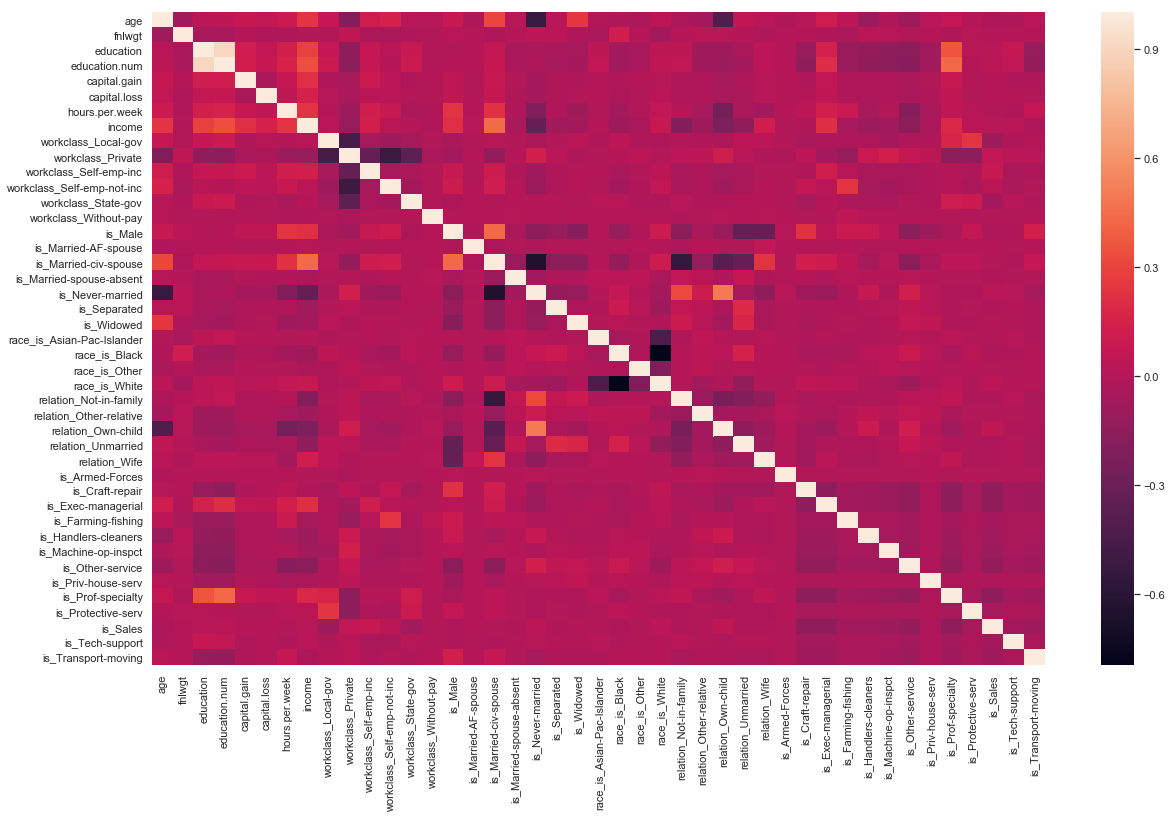

In [956]:
plt.figure(figsize=(20,12))
sns.heatmap(data.corr())

In [957]:
data.select_dtypes(exclude=[np.number]).shape

(30162, 1)

In [958]:
#data['foo']=np.where(data['native.country']=='United-States',1,0)

In [959]:
data.groupby('income').mean()

,age,fnlwgt,education,education.num,capital.gain,capital.loss,hours.per.week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,is_Farming-fishing,is_Handlers-cleaners,is_Machine-op-inspct,is_Other-service,is_Priv-house-serv,is_Prof-specialty,is_Protective-serv,is_Sales,is_Tech-support,is_Transport-moving
income,,,,,,,,,,,,,,,,,,,,,
0,36.60806,190338.646729,8.462126,9.629116,148.893838,53.448000,39.348592,0.064359,0.768518,0.020923,...,0.038580,0.055928,0.075969,0.135958,0.006268,0.098305,0.019158,0.115388,0.027986,0.055310
1,43.95911,188149.962174,9.972163,11.606420,3937.679808,193.750666,45.706580,0.081113,0.649441,0.079915,...,0.015317,0.011055,0.032632,0.017581,0.000133,0.241209,0.027970,0.129196,0.037027,0.042488


In [960]:
data.shape

(30162, 44)

In [988]:
y = data.income
X = data.drop(['income', 'education', 'native.country', 'fnlwgt'],axis=1)

The `income` column is dropped because it is the target variable.
`Education` is dropped because `education.num` is the coded variable for it. One can notice the high correlation between `education` and `education.num` in the heatmap.
`native country` is dropped because it showed very little feature importance in random forest

## Modelling

In [989]:
from sklearn.model_selection import train_test_split

In [990]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [991]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier as xgb
from sklearn import metrics

### Baseline model
In the baseline model, we predict the minority class for all our train and test (or validation) examples. The resulting accuracy will serve as a benchmark for the ML models. In other words, the sophisticated ML models should have an accuracy which should at least better the baseline one.

In [992]:
baseline_train = np.zeros(y_train.shape[0])
baseline_test = np.zeros(y_test.shape[0])
print('Accuracy on train data: %f%%' % (metrics.accuracy_score(y_train, baseline_train)))
print('Accuracy on test data: %f%%' %  (metrics.accuracy_score(y_test, baseline_test)))

Accuracy on train data: 0.753091%
Accuracy on test data: 0.746381%


### Random Forest classifier

In [993]:
rfmodel = RandomForestClassifier(n_estimators=300,oob_score=True,min_samples_split=5, max_depth=10,random_state=10)
rfmodel.fit(X_train,y_train)
print(rfmodel)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=True, random_state=10, verbose=0, warm_start=False)


In [994]:
def show_classifier_metrics(clf, y_train=y_train,y_test=y_test, print_classification_report=True, print_confusion_matrix=True):
    print(clf)
    if print_confusion_matrix:
        print('confusion matrix of training data')
        print(metrics.confusion_matrix(y_train, clf.predict(X_train)))
        print('confusion matrix of test data')
        print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
    if print_classification_report:
        print('classification report of test data')
        print(metrics.classification_report(y_test, clf.predict(X_test)))
    print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, clf.predict(X_test))*100))
    print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, clf.predict(X_train))*100))
    print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, clf.predict(X_test))))

In [995]:
show_classifier_metrics(rfmodel,y_train)
print('oob score = %f'% rfmodel.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=True, random_state=10, verbose=0, warm_start=False)
confusion matrix of training data
[[15280   620]
 [ 2250  2963]]
confusion matrix of test data
[[6440  314]
 [1007 1288]]
classification report of test data
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      6754
           1       0.80      0.56      0.66      2295

   micro avg       0.85      0.85      0.85      9049
   macro avg       0.83      0.76      0.78      9049
weighted avg       0.85      0.85      0.84      9049

Accuracy on test data: 85.401702%
Accuracy on training data: 86.406479%
Area under the ROC curve : 0.757365


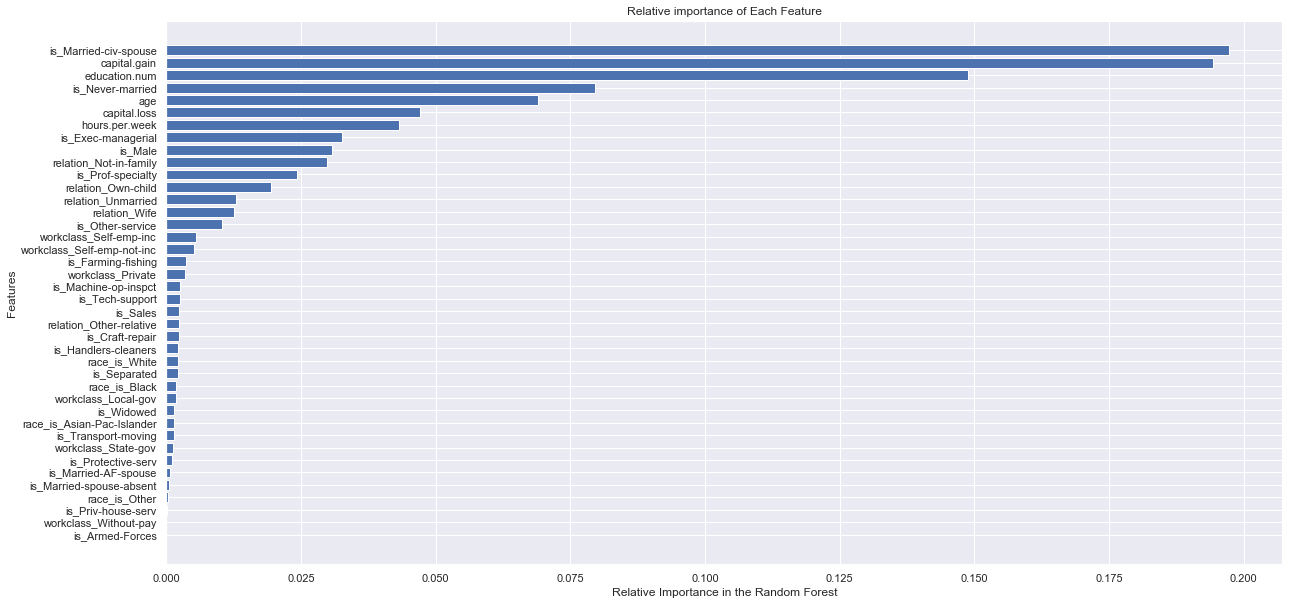

In [996]:
importance_list = rfmodel.feature_importances_
name_list = X_train.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(20,10))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Random forest: Grid Search and cross-validation

In [997]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [998]:
def grid_search(clf, parameters, X, y, n_jobs= -1, n_folds=4, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =2)
    else:
        print('Doing grid search')
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose =2)
    gs.fit(X, y)
    print("mean test score (weighted by split size) of CV rounds: ",gs.cv_results_['mean_test_score'] )
    print ("Best parameter set", gs.best_params_, "Corresponding mean CV score",gs.best_score_)
    best = gs.best_estimator_
    return best

In [999]:
rfmodel2 = RandomForestClassifier(min_samples_split=5,oob_score=True, n_jobs=-1,random_state=10)
parameters = {'n_estimators': [100,200,300], 'max_depth': [10,13,15,20]}
rfmodelCV = grid_search(rfmodel2, parameters,X_train,y_train)

Doing grid search
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.3min finished


mean test score (weighted by split size) of CV rounds:  [0.85610761 0.85563397 0.85587079 0.85501824 0.85672335 0.85643916
 0.85653389 0.85767063 0.85710226 0.85596552 0.85525506 0.85516033]
Best parameter set {'max_depth': 15, 'n_estimators': 200} Corresponding mean CV score 0.8576706294699948


In [1000]:
rfmodelCV.fit(X_train,y_train)
show_classifier_metrics(rfmodelCV,y_train)
print('oob score = %f'% rfmodelCV.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=10, verbose=0, warm_start=False)
confusion matrix of training data
[[15301   599]
 [ 1848  3365]]
confusion matrix of test data
[[6396  358]
 [ 926 1369]]
classification report of test data
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6754
           1       0.79      0.60      0.68      2295

   micro avg       0.86      0.86      0.86      9049
   macro avg       0.83      0.77      0.79      9049
weighted avg       0.85      0.86      0.85      9049

Accuracy on test data: 85.810587%
Accuracy on training data: 88.409984%
Area under the ROC curve : 0.771754
oo

## XGBoost 

In [1001]:
from xgboost.sklearn import XGBClassifier

In [1002]:
param = {}
param['learning_rate'] = 0.1
param['verbosity'] = 1
param['colsample_bylevel'] = 0.9
param['colsample_bytree'] = 0.9
param['subsample'] = 0.9
param['reg_lambda']= 1.5
param['max_depth'] = 5
param['n_estimators'] = 400
param['seed']=10
xgb= XGBClassifier(**param)
xgb.fit(X_train, y_train, eval_metric=['error'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.155212	validation_1-error:0.159797
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.15436	validation_1-error:0.158692
[2]	validation_0-error:0.154644	validation_1-error:0.158471
[3]	validation_0-error:0.149576	validation_1-error:0.154382
[4]	validation_0-error:0.147918	validation_1-error:0.153277
[5]	validation_0-error:0.147018	validation_1-error:0.151398
[6]	validation_0-error:0.147113	validation_1-error:0.152061
[7]	validation_0-error:0.147066	validation_1-error:0.151508
[8]	validation_0-error:0.146924	validation_1-error:0.151287
[9]	validation_0-error:0.146782	validation_1-error:0.151619
[10]	validation_0-error:0.14664	validation_1-error:0.151619
[11]	validation_0-error:0.146829	validation_1-error:0.151177
[12]	validation_0-error:0.145598	validation_1-error:0.149519
[13]	validation_0-error:0.145219	validation_1-error:0.1491

[132]	validation_0-error:0.121584	validation_1-error:0.131175
[133]	validation_0-error:0.121726	validation_1-error:0.131175
[134]	validation_0-error:0.121726	validation_1-error:0.131285
[135]	validation_0-error:0.121584	validation_1-error:0.130843
[136]	validation_0-error:0.121631	validation_1-error:0.130843
[137]	validation_0-error:0.121584	validation_1-error:0.130843
[138]	validation_0-error:0.1213	validation_1-error:0.130512
[139]	validation_0-error:0.1213	validation_1-error:0.130512
[140]	validation_0-error:0.1213	validation_1-error:0.13007
[141]	validation_0-error:0.121347	validation_1-error:0.129959
[142]	validation_0-error:0.121394	validation_1-error:0.129849
[143]	validation_0-error:0.121063	validation_1-error:0.130401
[144]	validation_0-error:0.12111	validation_1-error:0.130622
[145]	validation_0-error:0.120779	validation_1-error:0.130401
[146]	validation_0-error:0.120589	validation_1-error:0.130622
[147]	validation_0-error:0.120447	validation_1-error:0.130954
[148]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.9, verbosity=1)

In [1003]:
show_classifier_metrics(xgb,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.9, verbosity=1)
confusion matrix of training data
[[15070   830]
 [ 1733  3480]]
confusion matrix of test data
[[6361  393]
 [ 782 1513]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6754
           1       0.79      0.66      0.72      2295

   micro avg       0.87      0.87      0.87      9049
   macro avg       0.84      0.80      0.82      9049
weighted avg       0.87      0.87      0.87      9049

Accuracy on test data: 87.015140%
Accuracy on training data: 87.860560%
Area under the ROC curve : 0.800536


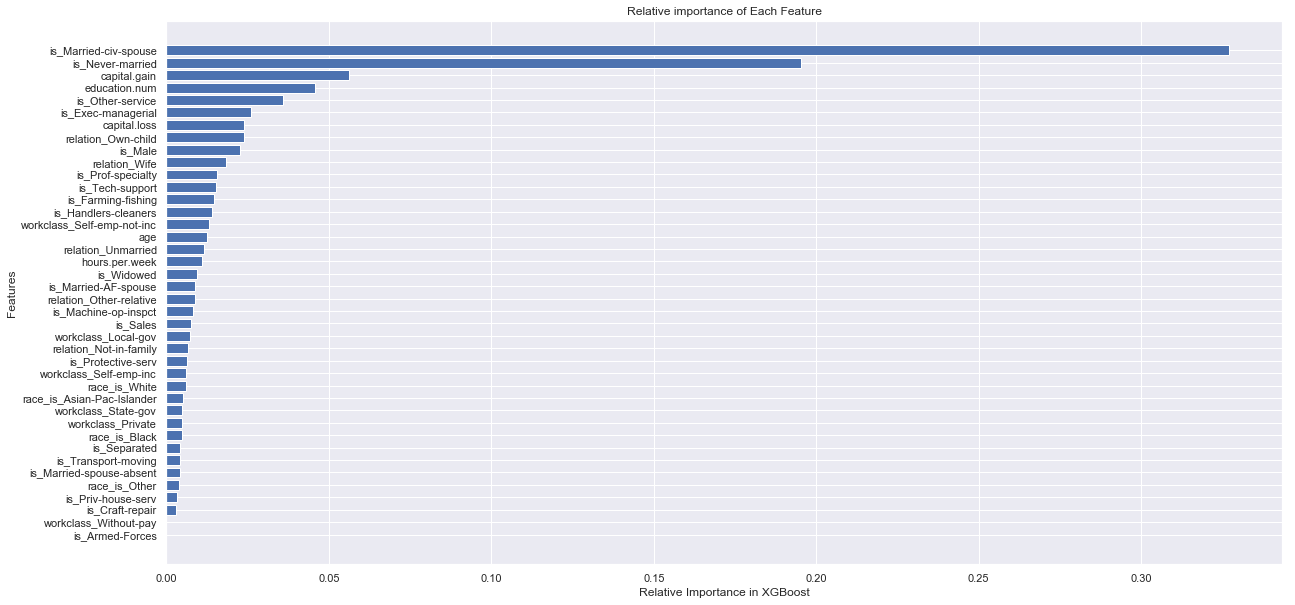

In [1004]:
importance_list = xgb.feature_importances_
name_list = X_train.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(20,10))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in XGBoost')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Grid search with cross validation: XGBoost model

In [1032]:
xgbmodel2 = XGBClassifier(seed=42)
param = {
'learning_rate': [0.1],
#'verbosity': [1],
'colsample_bylevel': [0.9],
'colsample_bytree': [0.9],
'subsample' : [0.9],
'n_estimators': [300],
'reg_lambda': [1.5,2],
'max_depth': [3,5,7],
 'seed': [10]   
}
xgbCV = grid_search(xgbmodel2, param,X_train,y_train)

Doing grid search
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.4min finished


mean test score (weighted by split size) of CV rounds:  [0.865912   0.86624355 0.86780656 0.86723819 0.86212286 0.86278596]
Best parameter set {'colsample_bylevel': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_lambda': 1.5, 'seed': 10, 'subsample': 0.9} Corresponding mean CV score 0.8678065646757922


In [1033]:
xgbCV.fit(X_train, y_train, eval_metric=['error'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.155212	validation_1-error:0.159797
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.15436	validation_1-error:0.158692
[2]	validation_0-error:0.154644	validation_1-error:0.158471
[3]	validation_0-error:0.149576	validation_1-error:0.154382
[4]	validation_0-error:0.147918	validation_1-error:0.153277
[5]	validation_0-error:0.147018	validation_1-error:0.151398
[6]	validation_0-error:0.147113	validation_1-error:0.152061
[7]	validation_0-error:0.147066	validation_1-error:0.151508
[8]	validation_0-error:0.146924	validation_1-error:0.151287
[9]	validation_0-error:0.146782	validation_1-error:0.151619
[10]	validation_0-error:0.14664	validation_1-error:0.151619
[11]	validation_0-error:0.146829	validation_1-error:0.151177
[12]	validation_0-error:0.145598	validation_1-error:0.149519
[13]	validation_0-error:0.145219	validation_1-error:0.1491

[132]	validation_0-error:0.121584	validation_1-error:0.131175
[133]	validation_0-error:0.121726	validation_1-error:0.131175
[134]	validation_0-error:0.121726	validation_1-error:0.131285
[135]	validation_0-error:0.121584	validation_1-error:0.130843
[136]	validation_0-error:0.121631	validation_1-error:0.130843
[137]	validation_0-error:0.121584	validation_1-error:0.130843
[138]	validation_0-error:0.1213	validation_1-error:0.130512
[139]	validation_0-error:0.1213	validation_1-error:0.130512
[140]	validation_0-error:0.1213	validation_1-error:0.13007
[141]	validation_0-error:0.121347	validation_1-error:0.129959
[142]	validation_0-error:0.121394	validation_1-error:0.129849
[143]	validation_0-error:0.121063	validation_1-error:0.130401
[144]	validation_0-error:0.12111	validation_1-error:0.130622
[145]	validation_0-error:0.120779	validation_1-error:0.130401
[146]	validation_0-error:0.120589	validation_1-error:0.130622
[147]	validation_0-error:0.120447	validation_1-error:0.130954
[148]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.9)

In [1034]:
show_classifier_metrics(xgbCV,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.9)
confusion matrix of training data
[[15070   830]
 [ 1733  3480]]
confusion matrix of test data
[[6361  393]
 [ 782 1513]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6754
           1       0.79      0.66      0.72      2295

   micro avg       0.87      0.87      0.87      9049
   macro avg       0.84      0.80      0.82      9049
weighted avg       0.87      0.87      0.87      9049

Accuracy on test data: 87.015140%
Accuracy on training data: 87.860560%
Area under the ROC curve : 0.800536


In [167]:
#X_test.iloc[np.where(y_test != xgbCV.predict(X_test))]

## Logistic regression

In [1006]:
from sklearn.linear_model import LogisticRegression

In [1007]:
logreg = LogisticRegression(C=0.8,random_state=42,max_iter=200)
logreg.fit(X_train, y_train)

/Users/debashis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [1008]:
show_classifier_metrics(logreg)

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
confusion matrix of training data
[[14776  1124]
 [ 2050  3163]]
confusion matrix of test data
[[6226  528]
 [ 905 1390]]
classification report of test data
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6754
           1       0.72      0.61      0.66      2295

   micro avg       0.84      0.84      0.84      9049
   macro avg       0.80      0.76      0.78      9049
weighted avg       0.84      0.84      0.84      9049

Accuracy on test data: 84.163996%
Accuracy on training data: 84.966608%
Area under the ROC curve : 0.763744


## Naive Bayes

In [977]:
from sklearn.naive_bayes import GaussianNB

In [1009]:
NBmodel = GaussianNB()

In [1010]:
NBmodel.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [1011]:
NBmodel.predict(X_test)

array([1, 0, 0, ..., 0, 0, 0])

In [1012]:
show_classifier_metrics(NBmodel,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)
confusion matrix of training data
[[13445  2455]
 [ 1309  3904]]
confusion matrix of test data
[[5694 1060]
 [ 588 1707]]
classification report of test data
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      6754
           1       0.62      0.74      0.67      2295

   micro avg       0.82      0.82      0.82      9049
   macro avg       0.76      0.79      0.77      9049
weighted avg       0.83      0.82      0.82      9049

Accuracy on test data: 81.788043%
Accuracy on training data: 82.172121%
Area under the ROC curve : 0.793423


### Stacked model

In [1013]:
def create_stacked_dataset(clfs,modelnames, X_train=X_train,X_test=X_test):
    X_train_stack, X_test_stack = X_train, X_test
    for clf,modelname in zip(clfs,modelnames):
        temptrain = pd.DataFrame(clf.predict(X_train),index = X_train.index,columns=[modelname+'_prediction'])
        temptest  = pd.DataFrame(clf.predict(X_test),index = X_test.index,columns=[modelname+'_prediction'])
        X_train_stack = pd.concat([X_train_stack, temptrain], axis=1)
        X_test_stack = pd.concat([X_test_stack, temptest], axis=1)
    return (X_train_stack,X_test_stack)

In [1014]:
X_train_stack,X_test_stack = create_stacked_dataset([NBmodel,rfmodel,logreg,xgb],modelnames=['NBmodel','rfmodel','logreg','xgb'])

In [1015]:
X_train_stack.head(2)

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,is_Priv-house-serv,is_Prof-specialty,is_Protective-serv,is_Sales,is_Tech-support,is_Transport-moving,NBmodel_prediction,rfmodel_prediction,logreg_prediction,xgb_prediction
29235,59,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14256,27,9,0,0,45,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [1016]:
param = {}
param['learning_rate'] = 0.1
param['verbosity'] = 1
param['colsample_bylevel'] = 0.9
param['colsample_bytree'] = 0.9
param['subsample'] = 0.9
param['reg_lambda']= 1.5
param['max_depth'] = 5#10
param['n_estimators'] = 400
param['seed']=10
xgbstack= XGBClassifier(**param)
xgbstack.fit(X_train_stack, y_train, eval_metric=['error'], eval_set=[(X_train_stack, y_train),(X_test_stack, y_test)],early_stopping_rounds=30)


[0]	validation_0-error:0.121158	validation_1-error:0.129517
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.123431	validation_1-error:0.133827
[2]	validation_0-error:0.122768	validation_1-error:0.130954
[3]	validation_0-error:0.122768	validation_1-error:0.132169
[4]	validation_0-error:0.122247	validation_1-error:0.130401
[5]	validation_0-error:0.121726	validation_1-error:0.130512
[6]	validation_0-error:0.121205	validation_1-error:0.129738
[7]	validation_0-error:0.1213	validation_1-error:0.129959
[8]	validation_0-error:0.121252	validation_1-error:0.129959
[9]	validation_0-error:0.1213	validation_1-error:0.129849
[10]	validation_0-error:0.121347	validation_1-error:0.129849
[11]	validation_0-error:0.121347	validation_1-error:0.129849
[12]	validation_0-error:0.121394	validation_1-error:0.129849
[13]	validation_0-error:0.121394	validation_1-error:0.129959

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.9, verbosity=1)

In [1017]:
print(metrics.classification_report(y_test, xgbstack.predict(X_test_stack)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, xgbstack.predict(X_test_stack))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, xgbstack.predict(X_train_stack))*100))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6754
           1       0.80      0.66      0.72      2295

   micro avg       0.87      0.87      0.87      9049
   macro avg       0.84      0.80      0.82      9049
weighted avg       0.87      0.87      0.87      9049

Accuracy on test data: 87.048293%
Accuracy on training data: 87.884242%


### Stacked model Grid Search

In [1018]:
xgbstackCV = XGBClassifier(seed=10)
param_grid = {}
param_grid['learning_rate'] = [0.1]
param_grid['colsample_bylevel'] = [0.9]
param_grid['colsample_bytree'] = [0.9]
param_grid['subsample'] = [0.9]
param_grid['n_estimators'] = [300]
param_grid['reg_lambda']= [1.5]
param_grid['seed'] =[10]
param_grid['max_depth'] = [3,5,8,10]
xgbstackCV_grid = grid_search(xgbstackCV, param_grid,X_train_stack,y_train)

Doing grid search
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.6min finished


mean test score (weighted by split size) of CV rounds:  [0.87761095 0.87339554 0.86558045 0.86202813]
Best parameter set {'colsample_bylevel': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 1.5, 'seed': 10, 'subsample': 0.9} Corresponding mean CV score 0.877610950599157


In [1019]:
xgbstackCV_grid.fit(X_train_stack, y_train, eval_metric=['error'], eval_set=[(X_train_stack, y_train),(X_test_stack, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.121394	validation_1-error:0.129849
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.121394	validation_1-error:0.129849
[2]	validation_0-error:0.121394	validation_1-error:0.129849
[3]	validation_0-error:0.121394	validation_1-error:0.129849
[4]	validation_0-error:0.121394	validation_1-error:0.129849
[5]	validation_0-error:0.121394	validation_1-error:0.129849
[6]	validation_0-error:0.121394	validation_1-error:0.129849
[7]	validation_0-error:0.121394	validation_1-error:0.129849
[8]	validation_0-error:0.121394	validation_1-error:0.129849
[9]	validation_0-error:0.121394	validation_1-error:0.129849
[10]	validation_0-error:0.121394	validation_1-error:0.129849
[11]	validation_0-error:0.121394	validation_1-error:0.129849
[12]	validation_0-error:0.121394	validation_1-error:0.129849
[13]	validation_0-error:0.121394	validation_1-error:0.12

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.9)

In [1020]:
print(metrics.classification_report(y_test, xgbstack.predict(X_test_stack)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, xgbstack.predict(X_test_stack))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, xgbstack.predict(X_train_stack))*100))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6754
           1       0.80      0.66      0.72      2295

   micro avg       0.87      0.87      0.87      9049
   macro avg       0.84      0.80      0.82      9049
weighted avg       0.87      0.87      0.87      9049

Accuracy on test data: 87.048293%
Accuracy on training data: 87.884242%


In [1021]:
from catboost import CatBoostClassifier

In [1022]:
catb = CatBoostClassifier(learning_rate=0.1,iterations=400,verbose=1,random_seed=10,eval_metric='Accuracy',rsm=0.9)

In [1023]:
catb.fit(X_train,y_train,eval_set=[(X_train,y_train), (X_test,y_test)],early_stopping_rounds=30)

0:	learn: 0.8211055	test: 0.8211055	test1: 0.8155597	best: 0.8155597 (0)	total: 45.8ms	remaining: 18.3s
1:	learn: 0.8436508	test: 0.8436508	test1: 0.8384352	best: 0.8384352 (1)	total: 90.1ms	remaining: 17.9s
2:	learn: 0.8455928	test: 0.8455928	test1: 0.8428556	best: 0.8428556 (2)	total: 134ms	remaining: 17.7s
3:	learn: 0.8468716	test: 0.8468716	test1: 0.8459498	best: 0.8459498 (3)	total: 176ms	remaining: 17.4s
4:	learn: 0.8467295	test: 0.8467295	test1: 0.8439607	best: 0.8459498 (3)	total: 218ms	remaining: 17.2s
5:	learn: 0.8467295	test: 0.8467295	test1: 0.8449552	best: 0.8459498 (3)	total: 260ms	remaining: 17.1s
6:	learn: 0.8485293	test: 0.8485293	test1: 0.8460603	best: 0.8460603 (6)	total: 308ms	remaining: 17.3s
7:	learn: 0.8500924	test: 0.8500924	test1: 0.8466129	best: 0.8466129 (7)	total: 350ms	remaining: 17.2s
8:	learn: 0.8515606	test: 0.8515606	test1: 0.8471654	best: 0.8471654 (8)	total: 396ms	remaining: 17.2s
9:	learn: 0.8524606	test: 0.8524606	test1: 0.8474970	best: 0.8474970 (9

81:	learn: 0.8644437	test: 0.8644437	test1: 0.8615317	best: 0.8615317 (81)	total: 3.9s	remaining: 15.1s
82:	learn: 0.8645858	test: 0.8645858	test1: 0.8616422	best: 0.8616422 (82)	total: 3.94s	remaining: 15s
83:	learn: 0.8647753	test: 0.8647753	test1: 0.8618632	best: 0.8618632 (83)	total: 3.98s	remaining: 15s
84:	learn: 0.8648226	test: 0.8648226	test1: 0.8623052	best: 0.8623052 (84)	total: 4.03s	remaining: 14.9s
85:	learn: 0.8649173	test: 0.8649173	test1: 0.8625262	best: 0.8625262 (85)	total: 4.06s	remaining: 14.8s
86:	learn: 0.8651068	test: 0.8651068	test1: 0.8621947	best: 0.8625262 (85)	total: 4.12s	remaining: 14.8s
87:	learn: 0.8650594	test: 0.8650594	test1: 0.8620842	best: 0.8625262 (85)	total: 4.16s	remaining: 14.7s
88:	learn: 0.8653436	test: 0.8653436	test1: 0.8620842	best: 0.8625262 (85)	total: 4.2s	remaining: 14.7s
89:	learn: 0.8655331	test: 0.8655331	test1: 0.8620842	best: 0.8625262 (85)	total: 4.23s	remaining: 14.6s
90:	learn: 0.8657225	test: 0.8657225	test1: 0.8623052	best: 0

163:	learn: 0.8708852	test: 0.8708852	test1: 0.8678307	best: 0.8680517 (161)	total: 7.47s	remaining: 10.7s
164:	learn: 0.8708379	test: 0.8708379	test1: 0.8679412	best: 0.8680517 (161)	total: 7.51s	remaining: 10.7s
165:	learn: 0.8706958	test: 0.8706958	test1: 0.8682727	best: 0.8682727 (165)	total: 7.55s	remaining: 10.6s
166:	learn: 0.8707431	test: 0.8707431	test1: 0.8684938	best: 0.8684938 (166)	total: 7.59s	remaining: 10.6s
167:	learn: 0.8708852	test: 0.8708852	test1: 0.8686043	best: 0.8686043 (167)	total: 7.63s	remaining: 10.5s
168:	learn: 0.8708379	test: 0.8708379	test1: 0.8686043	best: 0.8686043 (167)	total: 7.68s	remaining: 10.5s
169:	learn: 0.8710747	test: 0.8710747	test1: 0.8682727	best: 0.8686043 (167)	total: 7.72s	remaining: 10.4s
170:	learn: 0.8709800	test: 0.8709800	test1: 0.8682727	best: 0.8686043 (167)	total: 7.76s	remaining: 10.4s
171:	learn: 0.8709326	test: 0.8709326	test1: 0.8674992	best: 0.8686043 (167)	total: 7.81s	remaining: 10.4s
172:	learn: 0.8711694	test: 0.8711694

In [1024]:
show_classifier_metrics(catb)

confusion matrix of training data
[[15059   841]
 [ 1854  3359]]
confusion matrix of test data
[[6376  378]
 [ 805 1490]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6754
           1       0.80      0.65      0.72      2295

   micro avg       0.87      0.87      0.87      9049
   macro avg       0.84      0.80      0.82      9049
weighted avg       0.87      0.87      0.86      9049

Accuracy on test data: 86.926732%
Accuracy on training data: 87.235353%
Area under the ROC curve : 0.796635


In [1025]:
from imblearn.over_sampling import RandomOverSampler

In [1026]:
np.sum(y_train)/y_train.shape[0]

0.24690948704589588

In [1027]:
ros = RandomOverSampler(random_state=1,sampling_strategy='auto')

In [1028]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [1029]:
catb_ros = CatBoostClassifier(learning_rate=0.1,iterations=400,verbose=1,random_seed=10,eval_metric='Accuracy')

In [1030]:
catb_ros.fit(X_resampled,y_resampled,eval_set=[(X_resampled,y_resampled), (X_test,y_test)],early_stopping_rounds=30)

0:	learn: 0.7950629	test: 0.7950629	test1: 0.7417394	best: 0.7417394 (0)	total: 64.5ms	remaining: 25.7s
1:	learn: 0.8116667	test: 0.8116667	test1: 0.7788706	best: 0.7788706 (1)	total: 132ms	remaining: 26.2s
2:	learn: 0.8114465	test: 0.8114465	test1: 0.7806387	best: 0.7806387 (2)	total: 190ms	remaining: 25.1s
3:	learn: 0.8078302	test: 0.8078302	test1: 0.7753343	best: 0.7806387 (2)	total: 252ms	remaining: 24.9s
4:	learn: 0.8092138	test: 0.8092138	test1: 0.7748923	best: 0.7806387 (2)	total: 334ms	remaining: 26.4s
5:	learn: 0.8133019	test: 0.8133019	test1: 0.7767709	best: 0.7806387 (2)	total: 412ms	remaining: 27.1s
6:	learn: 0.8129560	test: 0.8129560	test1: 0.7780970	best: 0.7806387 (2)	total: 468ms	remaining: 26.3s
7:	learn: 0.8135220	test: 0.8135220	test1: 0.7790916	best: 0.7806387 (2)	total: 528ms	remaining: 25.9s
8:	learn: 0.8157233	test: 0.8157233	test1: 0.7787601	best: 0.7806387 (2)	total: 600ms	remaining: 26.1s
9:	learn: 0.8169497	test: 0.8169497	test1: 0.7814123	best: 0.7814123 (9)

81:	learn: 0.8478616	test: 0.8478616	test1: 0.8244005	best: 0.8248425 (77)	total: 4.99s	remaining: 19.4s
82:	learn: 0.8480818	test: 0.8480818	test1: 0.8249530	best: 0.8249530 (82)	total: 5.05s	remaining: 19.3s
83:	learn: 0.8482704	test: 0.8482704	test1: 0.8255056	best: 0.8255056 (83)	total: 5.11s	remaining: 19.2s
84:	learn: 0.8485535	test: 0.8485535	test1: 0.8250635	best: 0.8255056 (83)	total: 5.17s	remaining: 19.1s
85:	learn: 0.8484591	test: 0.8484591	test1: 0.8251741	best: 0.8255056 (83)	total: 5.23s	remaining: 19.1s
86:	learn: 0.8494340	test: 0.8494340	test1: 0.8267212	best: 0.8267212 (86)	total: 5.28s	remaining: 19s
87:	learn: 0.8494025	test: 0.8494025	test1: 0.8268317	best: 0.8268317 (87)	total: 5.34s	remaining: 18.9s
88:	learn: 0.8493711	test: 0.8493711	test1: 0.8266107	best: 0.8268317 (87)	total: 5.39s	remaining: 18.9s
89:	learn: 0.8494654	test: 0.8494654	test1: 0.8266107	best: 0.8268317 (87)	total: 5.45s	remaining: 18.8s
90:	learn: 0.8503459	test: 0.8503459	test1: 0.8271632	bes

162:	learn: 0.8560063	test: 0.8560063	test1: 0.8327992	best: 0.8330202 (160)	total: 9.65s	remaining: 14s
163:	learn: 0.8563522	test: 0.8563522	test1: 0.8329097	best: 0.8330202 (160)	total: 9.71s	remaining: 14s
164:	learn: 0.8563836	test: 0.8563836	test1: 0.8329097	best: 0.8330202 (160)	total: 9.77s	remaining: 13.9s
165:	learn: 0.8564465	test: 0.8564465	test1: 0.8329097	best: 0.8330202 (160)	total: 9.82s	remaining: 13.8s
166:	learn: 0.8566352	test: 0.8566352	test1: 0.8330202	best: 0.8330202 (160)	total: 9.89s	remaining: 13.8s
167:	learn: 0.8568868	test: 0.8568868	test1: 0.8330202	best: 0.8330202 (160)	total: 9.95s	remaining: 13.7s
168:	learn: 0.8566667	test: 0.8566667	test1: 0.8333518	best: 0.8333518 (168)	total: 10s	remaining: 13.7s
169:	learn: 0.8566667	test: 0.8566667	test1: 0.8334623	best: 0.8334623 (169)	total: 10.1s	remaining: 13.6s
170:	learn: 0.8566981	test: 0.8566981	test1: 0.8335728	best: 0.8335728 (170)	total: 10.1s	remaining: 13.6s
171:	learn: 0.8567296	test: 0.8567296	test1

239:	learn: 0.8608491	test: 0.8608491	test1: 0.8353409	best: 0.8356724 (231)	total: 14.1s	remaining: 9.39s
240:	learn: 0.8607233	test: 0.8607233	test1: 0.8346779	best: 0.8356724 (231)	total: 14.2s	remaining: 9.34s
241:	learn: 0.8606918	test: 0.8606918	test1: 0.8350094	best: 0.8356724 (231)	total: 14.2s	remaining: 9.27s
242:	learn: 0.8608176	test: 0.8608176	test1: 0.8351199	best: 0.8356724 (231)	total: 14.3s	remaining: 9.21s
243:	learn: 0.8608176	test: 0.8608176	test1: 0.8351199	best: 0.8356724 (231)	total: 14.3s	remaining: 9.14s
244:	learn: 0.8608176	test: 0.8608176	test1: 0.8350094	best: 0.8356724 (231)	total: 14.4s	remaining: 9.08s
245:	learn: 0.8611321	test: 0.8611321	test1: 0.8351199	best: 0.8356724 (231)	total: 14.4s	remaining: 9.03s
246:	learn: 0.8611950	test: 0.8611950	test1: 0.8350094	best: 0.8356724 (231)	total: 14.5s	remaining: 9s
247:	learn: 0.8611635	test: 0.8611635	test1: 0.8351199	best: 0.8356724 (231)	total: 14.6s	remaining: 8.98s
248:	learn: 0.8610377	test: 0.8610377	te

In [1031]:
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, catb_ros.predict(X_test))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_resampled, catb_ros.predict(X_resampled))*100))
print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, catb_ros.predict(X_test))))

Accuracy on test data: 83.567245%
Accuracy on training data: 86.066038%
Area under the ROC curve : 0.844897


### SMOTE

In [1035]:
from imblearn.over_sampling import SMOTE

In [1061]:
smt = SMOTE(random_state=10,sampling_strategy=0.7)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

In [1062]:
y_train.value_counts()

0    15900
1     5213
Name: income, dtype: int64

In [1063]:
np.bincount(y_train_smt)

array([15900, 11130])

In [1064]:
catb_smote = CatBoostClassifier(learning_rate=0.1,iterations=400,verbose=1,random_seed=10,eval_metric='Accuracy')

In [1065]:
catb_smote.fit(X_train_smt,y_train_smt,eval_set=[(X_train_smt,y_train_smt), (X_test,y_test)],early_stopping_rounds=30)

0:	learn: 0.7903071	test: 0.7903071	test1: 0.7648359	best: 0.7648359 (0)	total: 60.5ms	remaining: 24.2s
1:	learn: 0.8045875	test: 0.8045875	test1: 0.7898110	best: 0.7898110 (1)	total: 121ms	remaining: 24.1s
2:	learn: 0.8081391	test: 0.8081391	test1: 0.8255056	best: 0.8255056 (2)	total: 178ms	remaining: 23.6s
3:	learn: 0.8144654	test: 0.8144654	test1: 0.8228534	best: 0.8255056 (2)	total: 232ms	remaining: 23s
4:	learn: 0.8145394	test: 0.8145394	test1: 0.8246215	best: 0.8255056 (2)	total: 309ms	remaining: 24.4s
5:	learn: 0.8156493	test: 0.8156493	test1: 0.8077136	best: 0.8255056 (2)	total: 372ms	remaining: 24.5s
6:	learn: 0.8164632	test: 0.8164632	test1: 0.8093712	best: 0.8255056 (2)	total: 446ms	remaining: 25.1s
7:	learn: 0.8172771	test: 0.8172771	test1: 0.8113604	best: 0.8255056 (2)	total: 513ms	remaining: 25.1s
8:	learn: 0.8187199	test: 0.8187199	test1: 0.8123550	best: 0.8255056 (2)	total: 621ms	remaining: 27s
9:	learn: 0.8183870	test: 0.8183870	test1: 0.8097027	best: 0.8255056 (2)	tot

79:	learn: 0.8672586	test: 0.8672586	test1: 0.8470549	best: 0.8473865 (78)	total: 6.05s	remaining: 24.2s
80:	learn: 0.8672586	test: 0.8672586	test1: 0.8469444	best: 0.8473865 (78)	total: 6.1s	remaining: 24s
81:	learn: 0.8676656	test: 0.8676656	test1: 0.8476075	best: 0.8476075 (81)	total: 6.16s	remaining: 23.9s
82:	learn: 0.8677026	test: 0.8677026	test1: 0.8479390	best: 0.8479390 (82)	total: 6.22s	remaining: 23.7s
83:	learn: 0.8679615	test: 0.8679615	test1: 0.8478285	best: 0.8479390 (82)	total: 6.31s	remaining: 23.7s
84:	learn: 0.8682945	test: 0.8682945	test1: 0.8479390	best: 0.8479390 (82)	total: 6.37s	remaining: 23.6s
85:	learn: 0.8684425	test: 0.8684425	test1: 0.8478285	best: 0.8479390 (82)	total: 6.42s	remaining: 23.4s
86:	learn: 0.8679985	test: 0.8679985	test1: 0.8474970	best: 0.8479390 (82)	total: 6.48s	remaining: 23.3s
87:	learn: 0.8684055	test: 0.8684055	test1: 0.8476075	best: 0.8479390 (82)	total: 6.55s	remaining: 23.2s
88:	learn: 0.8687384	test: 0.8687384	test1: 0.8476075	best

158:	learn: 0.8775435	test: 0.8775435	test1: 0.8525804	best: 0.8525804 (158)	total: 14.8s	remaining: 22.4s
159:	learn: 0.8775065	test: 0.8775065	test1: 0.8526909	best: 0.8526909 (159)	total: 14.9s	remaining: 22.3s
160:	learn: 0.8776175	test: 0.8776175	test1: 0.8529119	best: 0.8529119 (160)	total: 15s	remaining: 22.3s
161:	learn: 0.8777654	test: 0.8777654	test1: 0.8526909	best: 0.8529119 (160)	total: 15.1s	remaining: 22.2s
162:	learn: 0.8778394	test: 0.8778394	test1: 0.8523594	best: 0.8529119 (160)	total: 15.2s	remaining: 22s
163:	learn: 0.8782094	test: 0.8782094	test1: 0.8528014	best: 0.8529119 (160)	total: 15.2s	remaining: 21.9s
164:	learn: 0.8782094	test: 0.8782094	test1: 0.8524699	best: 0.8529119 (160)	total: 15.3s	remaining: 21.8s
165:	learn: 0.8780244	test: 0.8780244	test1: 0.8523594	best: 0.8529119 (160)	total: 15.3s	remaining: 21.6s
166:	learn: 0.8780614	test: 0.8780614	test1: 0.8523594	best: 0.8529119 (160)	total: 15.4s	remaining: 21.4s
167:	learn: 0.8780614	test: 0.8780614	tes

235:	learn: 0.8824269	test: 0.8824269	test1: 0.8552326	best: 0.8556747 (230)	total: 21.1s	remaining: 14.7s
236:	learn: 0.8829079	test: 0.8829079	test1: 0.8557852	best: 0.8557852 (236)	total: 21.2s	remaining: 14.6s
237:	learn: 0.8827969	test: 0.8827969	test1: 0.8555642	best: 0.8557852 (236)	total: 21.3s	remaining: 14.5s
238:	learn: 0.8829449	test: 0.8829449	test1: 0.8555642	best: 0.8557852 (236)	total: 21.4s	remaining: 14.4s
239:	learn: 0.8827229	test: 0.8827229	test1: 0.8560062	best: 0.8560062 (239)	total: 21.5s	remaining: 14.3s
240:	learn: 0.8828709	test: 0.8828709	test1: 0.8554536	best: 0.8560062 (239)	total: 21.5s	remaining: 14.2s
241:	learn: 0.8829819	test: 0.8829819	test1: 0.8554536	best: 0.8560062 (239)	total: 21.6s	remaining: 14.1s
242:	learn: 0.8829079	test: 0.8829079	test1: 0.8555642	best: 0.8560062 (239)	total: 21.7s	remaining: 14s
243:	learn: 0.8829819	test: 0.8829819	test1: 0.8557852	best: 0.8560062 (239)	total: 21.8s	remaining: 13.9s
244:	learn: 0.8830189	test: 0.8830189	t

312:	learn: 0.8852386	test: 0.8852386	test1: 0.8581059	best: 0.8582164 (301)	total: 26.8s	remaining: 7.45s
313:	learn: 0.8852386	test: 0.8852386	test1: 0.8581059	best: 0.8582164 (301)	total: 26.9s	remaining: 7.36s
314:	learn: 0.8852756	test: 0.8852756	test1: 0.8581059	best: 0.8582164 (301)	total: 26.9s	remaining: 7.27s
315:	learn: 0.8852756	test: 0.8852756	test1: 0.8581059	best: 0.8582164 (301)	total: 27.1s	remaining: 7.2s
316:	learn: 0.8852756	test: 0.8852756	test1: 0.8581059	best: 0.8582164 (301)	total: 27.2s	remaining: 7.12s
317:	learn: 0.8851646	test: 0.8851646	test1: 0.8579954	best: 0.8582164 (301)	total: 27.2s	remaining: 7.03s
318:	learn: 0.8851646	test: 0.8851646	test1: 0.8578848	best: 0.8582164 (301)	total: 27.3s	remaining: 6.94s
319:	learn: 0.8854236	test: 0.8854236	test1: 0.8575533	best: 0.8582164 (301)	total: 27.4s	remaining: 6.85s
320:	learn: 0.8855716	test: 0.8855716	test1: 0.8575533	best: 0.8582164 (301)	total: 27.4s	remaining: 6.75s
321:	learn: 0.8854606	test: 0.8854606	

In [1067]:
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, catb_smote.predict(X_test))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train_smt, catb_smote.predict(X_train_smt))*100))
print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, catb_ros.predict(X_test))))

Accuracy on test data: 85.821638%
Accuracy on training data: 88.472068%
Area under the ROC curve : 0.844897


In [1045]:
print(metrics.classification_report(y_test, catb_smote.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      6754
           1       0.67      0.78      0.72      2295

   micro avg       0.85      0.85      0.85      9049
   macro avg       0.80      0.83      0.81      9049
weighted avg       0.86      0.85      0.85      9049

